In [1]:
%pip install darts
%matplotlib widget

Note: you may need to restart the kernel to use updated packages.


In [2]:
## Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler
from pytorch_lightning.callbacks import ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from pytorch_lightning.callbacks import EarlyStopping
from pathlib import Path
import optuna
from tqdm import tqdm
from typing import Dict, Tuple
import torch.distributed as dist

dist.init_process_group(backend='nccl', init_method='env://')

from darts.metrics import rmse, mae
import warnings
warnings.filterwarnings('ignore')

In [6]:
def split_data_into_parts(data: pd.DataFrame, parts: int = 15) -> Dict[str, pd.DataFrame]:
    # Split data into parts
    chunk_size = len(data) // parts
    return {f"{idx+1}": data.iloc[idx * chunk_size:(idx + 1) * chunk_size] for idx in range(parts)}

def load_data(data_dir: str) -> Tuple[Dict, Dict]:
    data_path = Path(data_dir)
    all_data = {}
    all_data_split = {}

    # Find all parquet files
    parquet_files = list(data_path.glob("**/df*.parquet"))
    print(f"Found {len(parquet_files)} parquet files")

    for file_path in tqdm(parquet_files, desc="Processing cells", unit="cell"):
        # Extract cell number from parent directory name
        file_name = file_path.stem  
        cell_number = file_name.replace('df_', '')  
        cell_name = f'C{cell_number}'  
        tqdm.write(f"Processing {cell_name} ...")
            
        # Load and process data
        data = pd.read_parquet(file_path)
        data['Absolute_Time[yyyy-mm-dd hh:mm:ss]'] = pd.to_datetime(data['Absolute_Time[yyyy-mm-dd hh:mm:ss]'])
        
        # Select relevant columns
        data = data[['Absolute_Time[yyyy-mm-dd hh:mm:ss]', 'Current[A]', 'Voltage[V]', 
                    'Temperature[°C]', 'SOH_ZHU']]
        
        # Resample to hourly
        data.set_index('Absolute_Time[yyyy-mm-dd hh:mm:ss]', inplace=True)
        data_hourly = data.resample('h').mean().reset_index()
        
        # Fill missing values
        data_hourly.interpolate(method='linear', inplace=True)
        data_hourly['SOH_ZHU'] = data_hourly['SOH_ZHU'].fillna(1)
        
        # Convert to time series for full data
        target_series_full = TimeSeries.from_dataframe(data_hourly, 'Absolute_Time[yyyy-mm-dd hh:mm:ss]', 'SOH_ZHU')
        covariates_full = TimeSeries.from_dataframe(data_hourly, 'Absolute_Time[yyyy-mm-dd hh:mm:ss]', ['Current[A]', 'Voltage[V]', 'Temperature[°C]'])
        target_series_full, covariates_full = target_series_full.slice_intersect(covariates_full), covariates_full.slice_intersect(target_series_full)
        scaler_full = Scaler(scaler=MinMaxScaler(feature_range=(-1,1)))
        covariates_scaled_full = scaler_full.fit_transform(covariates_full)
        
        all_data[cell_name] = {'target': target_series_full, 'covariates_scaled': covariates_scaled_full}

        # Split data into parts and process each part
        split_data = split_data_into_parts(data_hourly)
        for part_idx, df_part in split_data.items():
            part_name = f"{cell_name}_{part_idx}"
            target_series_part = TimeSeries.from_dataframe(df_part, 'Absolute_Time[yyyy-mm-dd hh:mm:ss]', 'SOH_ZHU')
            covariates_part = TimeSeries.from_dataframe(df_part, 'Absolute_Time[yyyy-mm-dd hh:mm:ss]', ['Current[A]', 'Voltage[V]', 'Temperature[°C]'])
            target_series_part, covariates_part = target_series_part.slice_intersect(covariates_part), covariates_part.slice_intersect(target_series_part)
            scaler_part = Scaler(scaler=MinMaxScaler(feature_range=(-1,1)))
            covariates_scaled_part = scaler_part.fit_transform(covariates_part)
            
            all_data_split[part_name] = {'target': target_series_part, 'covariates_scaled': covariates_scaled_part}

    return all_data, all_data_split

data_dir = "../01_Datenaufbereitung/Output/Calculated/"
all_data, all_data_split = load_data(data_dir)

Found 15 parquet files


Processing cells:   0%|          | 0/15 [00:00<?, ?cell/s]

Processing C01 ...


Processing cells:   7%|▋         | 1/15 [00:09<02:11,  9.40s/cell]

Processing C03 ...


Processing cells:  13%|█▎        | 2/15 [00:15<01:33,  7.21s/cell]

Processing C05 ...


Processing cells:  20%|██        | 3/15 [00:21<01:20,  6.72s/cell]

Processing C07 ...


Processing cells:  27%|██▋       | 4/15 [00:27<01:11,  6.47s/cell]

Processing C09 ...


Processing cells:  33%|███▎      | 5/15 [00:30<00:53,  5.38s/cell]

Processing C11 ...


Processing cells:  40%|████      | 6/15 [00:34<00:43,  4.79s/cell]

Processing C13 ...


Processing cells:  47%|████▋     | 7/15 [00:35<00:29,  3.70s/cell]

Processing C15 ...


Processing cells:  53%|█████▎    | 8/15 [00:37<00:22,  3.15s/cell]

Processing C17 ...


Processing cells:  60%|██████    | 9/15 [00:43<00:24,  4.00s/cell]

Processing C19 ...


Processing cells:  67%|██████▋   | 10/15 [00:49<00:22,  4.59s/cell]

Processing C21 ...


Processing cells:  73%|███████▎  | 11/15 [00:55<00:19,  4.95s/cell]

Processing C23 ...


Processing cells:  80%|████████  | 12/15 [01:01<00:16,  5.34s/cell]

Processing C25 ...


Processing cells:  87%|████████▋ | 13/15 [01:05<00:09,  4.93s/cell]

Processing C27 ...


Processing cells:  93%|█████████▎| 14/15 [01:11<00:05,  5.17s/cell]

Processing C29 ...


Processing cells: 100%|██████████| 15/15 [01:15<00:00,  5.02s/cell]


In [9]:
def inspect_data_ranges(data_dict: dict):
   """
   Inspect time ranges and value ranges for each battery in the data dictionary
   """
   for cell_name, cell_data in data_dict.items():
       print(f"\n=== {cell_name} ===")
       
       # Get target data range
       target = cell_data['target']
       target_values = target.values().flatten()  # Flatten array for calculation
       print("\nTarget (SOH_ZHU):")
       print(f"Time Range: {target.start_time()} to {target.end_time()}")
       print(f"Value Range: {target_values.min():.4f} to {target_values.max():.4f}")
       print(f"Number of Data Points: {len(target)}")
       
       # Get covariates data range
       covariates = cell_data['covariates_scaled']
       cov_values = covariates.values()
       print("\nCovariates (scaled):")
       for i, feature in enumerate(covariates.components):
           values = cov_values[:, i].flatten()
           print(f"{feature}:")
           print(f"Value Range: {values.min():.4f} to {values.max():.4f}")

# View all data ranges
print("All Data Ranges:")
inspect_data_ranges(all_data_split)

All Data Ranges:

=== C01_1 ===

Target (SOH_ZHU):
Time Range: 2023-02-02 09:00:00 to 2023-02-17 09:00:00
Value Range: 0.9895 to 1.0000
Number of Data Points: 361

Covariates (scaled):
Current[A]:
Value Range: -1.0000 to 1.0000
Voltage[V]:
Value Range: -1.0000 to 1.0000
Temperature[°C]:
Value Range: -1.0000 to 1.0000

=== C01_2 ===

Target (SOH_ZHU):
Time Range: 2023-02-17 10:00:00 to 2023-03-04 10:00:00
Value Range: 0.9818 to 0.9895
Number of Data Points: 361

Covariates (scaled):
Current[A]:
Value Range: -1.0000 to 1.0000
Voltage[V]:
Value Range: -1.0000 to 1.0000
Temperature[°C]:
Value Range: -1.0000 to 1.0000

=== C01_3 ===

Target (SOH_ZHU):
Time Range: 2023-03-04 11:00:00 to 2023-03-19 11:00:00
Value Range: 0.9792 to 0.9818
Number of Data Points: 361

Covariates (scaled):
Current[A]:
Value Range: -1.0000 to 1.0000
Voltage[V]:
Value Range: -1.0000 to 1.0000
Temperature[°C]:
Value Range: -1.0000 to 1.0000

=== C01_4 ===

Target (SOH_ZHU):
Time Range: 2023-03-19 12:00:00 to 2023-04-

In [10]:
def split_cell_data(all_data: dict, train=13, val=1, test=1, parts = 15) -> Tuple[Dict, Dict, Dict]:
   n_train = train*parts
   n_val = val*parts
   n_test = test*parts
   part_names = list(all_data.keys())
   np.random.seed(773)
   np.random.shuffle(part_names)

   train_data = {part: all_data[part] for part in part_names[:n_train]}
   val_data = {part: all_data[part] for part in part_names[n_train:n_train + n_val]}
   test_data = {part: all_data[part] for part in part_names[n_train + n_val:n_train + n_val + n_test]}

   print(f"Data split completed:")
   print(f"Training set: {len(train_data)} parts")
   print(f"Validation set: {len(val_data)} parts")
   print(f"Test set: {len(test_data)} parts")
   
   return train_data, val_data, test_data

# Usage example:
train_data, val_data, test_data = split_cell_data(all_data_split)
inspect_data_ranges(train_data)

Data split completed:
Training set: 195 parts
Validation set: 15 parts
Test set: 15 parts

=== C01_5 ===

Target (SOH_ZHU):
Time Range: 2023-04-03 13:00:00 to 2023-04-18 13:00:00
Value Range: 0.9675 to 0.9729
Number of Data Points: 361

Covariates (scaled):
Current[A]:
Value Range: -1.0000 to 1.0000
Voltage[V]:
Value Range: -1.0000 to 1.0000
Temperature[°C]:
Value Range: -1.0000 to 1.0000

=== C03_3 ===

Target (SOH_ZHU):
Time Range: 2023-02-28 11:00:00 to 2023-03-13 11:00:00
Value Range: 0.9772 to 0.9843
Number of Data Points: 313

Covariates (scaled):
Current[A]:
Value Range: -1.0000 to 1.0000
Voltage[V]:
Value Range: -1.0000 to 1.0000
Temperature[°C]:
Value Range: -1.0000 to 1.0000

=== C07_8 ===

Target (SOH_ZHU):
Time Range: 2023-05-02 22:00:00 to 2023-05-15 16:00:00
Value Range: 0.9264 to 0.9332
Number of Data Points: 307

Covariates (scaled):
Current[A]:
Value Range: -1.0000 to 1.0000
Voltage[V]:
Value Range: -1.0000 to 1.0000
Temperature[°C]:
Value Range: -1.0000 to 1.0000

===

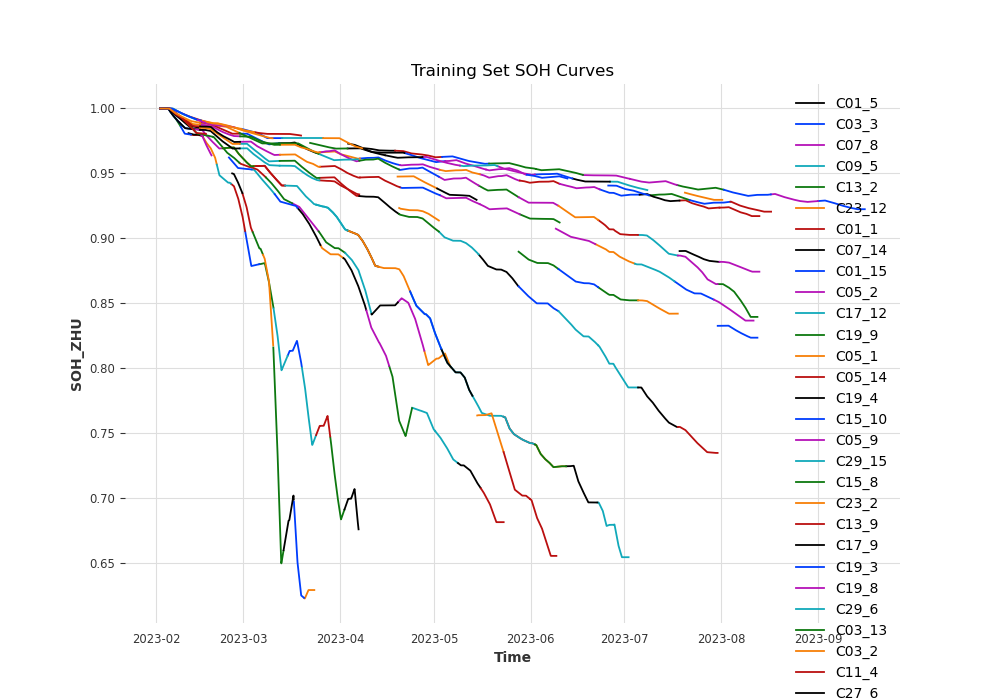

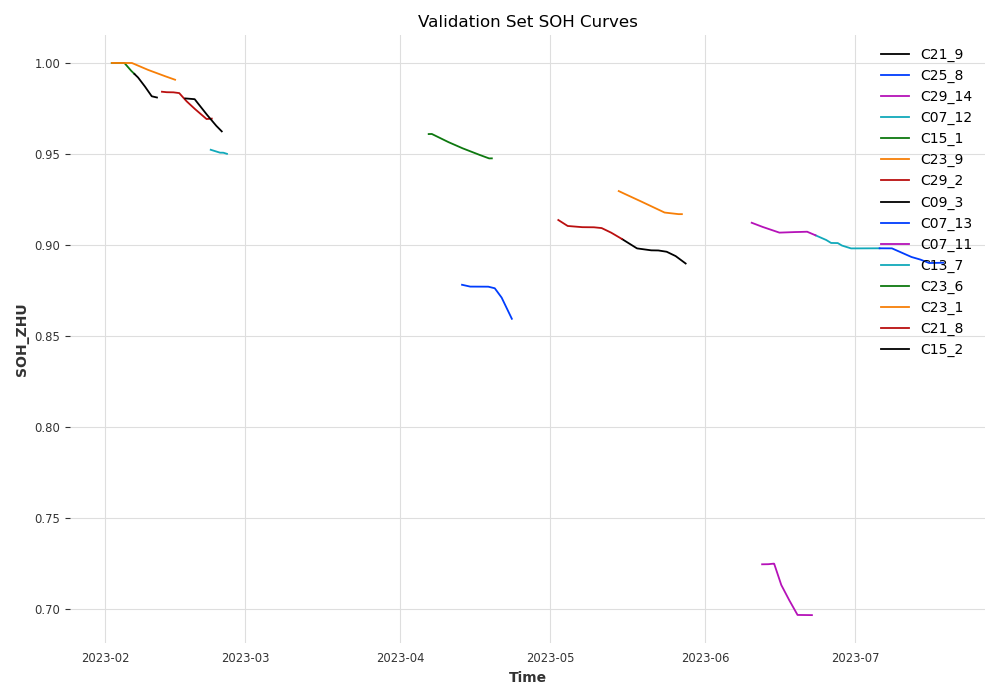

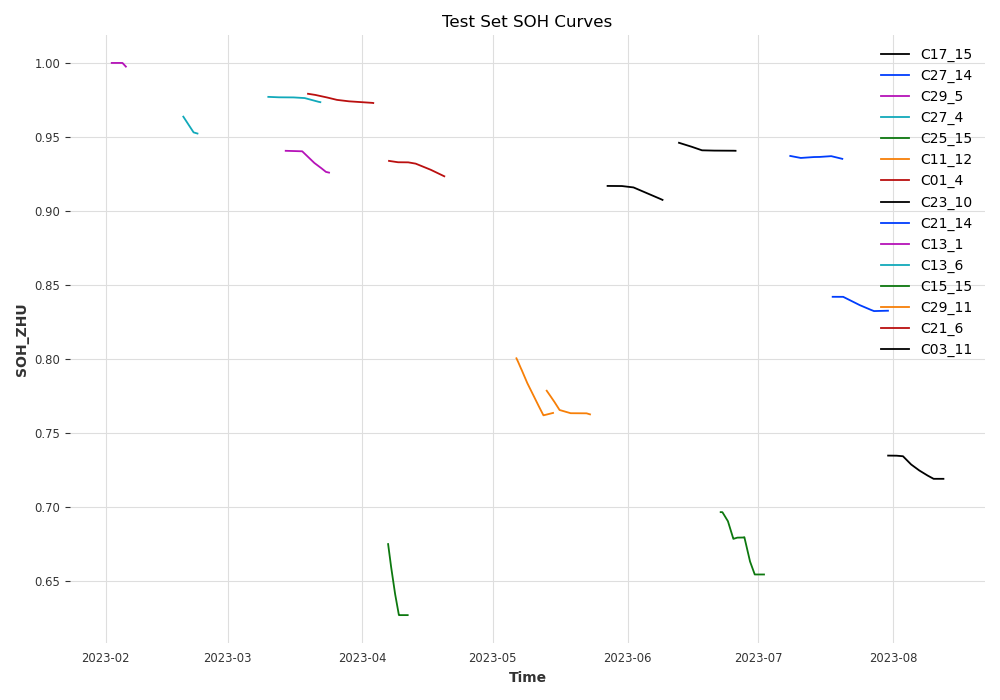

In [11]:
def plot_dataset_soh(data_dict: dict, title: str, figsize=(10, 7)):
    plt.figure(figsize=figsize)
    
    # Plot each cell's SOH
    for cell_name, cell_data in data_dict.items():
        target = cell_data['target']
        plt.plot(target.time_index, target.values().flatten(), label=cell_name)
    
    plt.title(f'{title} Set SOH Curves')
    plt.xlabel('Time')
    plt.ylabel('SOH_ZHU')
    plt.grid(True)
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

# Plot all three datasets
plot_dataset_soh(train_data, "Training")
plot_dataset_soh(val_data, "Validation")
plot_dataset_soh(test_data, "Test")

In [12]:
def prepare_data(data):
    targets = []
    covariates = []
    for cell_data in data.values():
        targets.append(cell_data['target'])
        covariates.append(cell_data['covariates_scaled'])
    
    series = targets[0]
    cov = covariates[0]
    for i in range(1, len(targets)):
        series = series.concatenate(targets[i], ignore_time_axis=True)
        cov = cov.concatenate(covariates[i], ignore_time_axis=True)
    return series, cov

In [15]:
# Optuna objective function
def objective(trial):
    # Define hyperparameter search space
    # 1. Search - Basic structure
    input_chunk_length = trial.suggest_int("input_chunk_length", 24, 48, step=12)
    output_chunk_length = trial.suggest_int("output_chunk_length", 1, 24, step=12)
    num_blocks = trial.suggest_int("num_blocks", 2, 5)
    num_stacks = trial.suggest_int("num_stacks", 2, 5)
    num_layers = trial.suggest_int("num_layers", 2, 5)  
    activation = trial.suggest_categorical("activation", ["ReLU", "LeakyReLU"])
    # 2. Search - Training parameters
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-4)
    layer_widths = trial.suggest_categorical("layer_widths", [128, 256, 512])
    dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.5)


    # expansion_coefficient_dim = trial.suggest_int("expansion_coefficient_dim", 8, 32, step=8)
    # trend_polynomial_degree = trial.suggest_int("trend_polynomial_degree", 1, 3)

    # Define and train model
    model = NBEATSModel(
        input_chunk_length=input_chunk_length,
        output_chunk_length=output_chunk_length,
        num_blocks=num_blocks,
        num_stacks=num_stacks,
        batch_size=batch_size,
        num_layers=num_layers,
        layer_widths=layer_widths,
        dropout=dropout_rate,
        # expansion_coefficient_dim=expansion_coefficient_dim, 
        # trend_polynomial_degree=trend_polynomial_degree, 
        optimizer_kwargs={"lr": learning_rate},
        random_state=773,
        activation = activation,
        pl_trainer_kwargs={
            "accelerator": "gpu",
            "devices": "auto",
            "strategy": "dp",
            "callbacks": [
              ModelCheckpoint(monitor="val_loss", mode="min", save_top_k=1)],
            "enable_checkpointing": True
        }
    )
    train_series, train_cov = prepare_data(train_data)
    val_series, val_cov = prepare_data(val_data)
    
    model.fit(series=train_series, past_covariates=train_cov, 
              val_series=val_series, val_past_covariates=val_cov, epochs=100)  
    
    # Retrieve best validation loss directly from the training process
    best_val_loss = model.trainer.checkpoint_callback.best_model_score.item() 
    
    return best_val_loss



In [16]:
# Optuna call with progress bar
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, n_jobs=2) 

# Best trial
print("Best trial:")
trial = study.best_trial
print(f"  Value (MAE): {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-01-09 19:54:17,787] A new study created in memory with name: no-name-0e5d9ebb-cec5-4a84-9ffa-64af4cc2a907
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 2.6 M  | train
-------------------------------------------------------------
2.6 M     Trainable params
1.9 K     Non-trainable params
2.6 M     Total params
10.492    Total estimated model params size (MB)
156       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...
[W 2025-01-09 19:58:20,982] Trial 0 failed with parameters: {'input_chunk_length': 24, 'output_chunk_length': 13, 'num_blocks': 3, 'num_stacks': 3, 'num_layers': 5, 'activation': 'ReLU', 'batch_size': 16, 'learning_rate': 9.831391495851304e-05, 'layer_widths': 256, 'dropout_rate': 0.36025768992804297} because of the following error: NameError("name 'exit' is not defined").
Traceback (most recent call last):
  File "c:\Users\zzhuqshun\.conda\envs\ML\lib\site-packages\pytorch_lightning\trainer\call.py", line 47, in _call_and_handle_interrupt
    return trainer_fn(*args, **kwargs)
  File "c:\Users\zzhuqshun\.conda\envs\ML\lib\site-packages\pytorch_lightning\trainer\trainer.py", line 574, in _fit_impl
    self._run(model, ckpt_path=ckpt_path)
  File "c:\Users\zzhuqshun\.conda\envs\ML\lib\site-packages\pytorch_lightning\trainer\trainer.py", line 981, in _run
    results = self._run_stage()
  File "c:\Users\zzhuqshun\.conda\envs\M

NameError: name 'exit' is not defined

In [21]:
# best_params = {'input_chunk_length': 33, 
#                'output_chunk_length': 1, 
#                'num_blocks': 4, 
#                'num_stacks': 3, 
#                'activation': 'LeakyReLU', 
#                'batch_size': 32, 
#                'learning_rate': 0.00041328603854847963,
#                "expansion_coefficient_dim":16,
#                "trend_polynomial_degree":2
#                }

# best_model = NBEATSModel(
#     input_chunk_length=best_params["input_chunk_length"],
#     output_chunk_length=best_params["output_chunk_length"],
#     num_blocks=best_params["num_blocks"],
#     num_stacks=best_params["num_stacks"],
#     batch_size=best_params["batch_size"],
#     expansion_coefficient_dim=best_params["expansion_coefficient_dim"],  
#     trend_polynomial_degree=best_params["trend_polynomial_degree"],  
#     optimizer_kwargs={"lr": best_params["learning_rate"]},  
#     random_state=773,  
#     activation=best_params["activation"],
#     pl_trainer_kwargs={ 
#         "accelerator": "gpu",
#         "devices": 1,
#         "callbacks": [
#             ModelCheckpoint(monitor="val_loss", mode="min", save_top_k=1)
#         ],
#         "enable_checkpointing": True
#     }
# )

# train_series, train_cov = prepare_data(train_data)
# val_series, val_cov = prepare_data(val_data)
# best_model.fit(series=train_series, past_covariates=train_cov, 
#                val_series=val_series, val_past_covariates=val_cov, epochs=500, verbose=True)

# best_model.save('best_nbeats_model')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 2.9 M  | train
-------------------------------------------------------------
2.9 M     Trainable params
6.4 K     Non-trainable params
2.9 M     Total params
11.614    Total estimated model params size (MB)
144       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [36]:
# def prepare_test_data(data):
#     series = []
#     cov = []
#     for cell_data in data.values():
#         series.append(cell_data['target'])
#         cov.append(cell_data['covariates_scaled'])
#     return series, cov

# def prdictions(model_path:str, test_data):
#     model = NBEATSModel.load(model_path)

#     test_series, test_cov = [], []
#     for cell_data in test_data.values():
#         test_series.append(cell_data['target'])
#         test_cov.append(cell_data['covariates_scaled'])
        
#     start = model.input_chunk_length + model.output_chunk_length
#     pred_test = model.historical_forecasts(
#         series=test_series,
#         past_covariates=test_cov,
#         start=start,
#         forecast_horizon=model.output_chunk_length,
#         retrain=False,
#         verbose=True
#     )

#     backtest_rmse = rmse(test_series, pred_test)
#     backtest_mae = mae(test_series, pred_test)
#     print(f'Backtest RMSE of Testdaten = {backtest_rmse}')
#     print(f'Backtest MAE of Testdaten = {backtest_rmse}')
    
#     cell_ids = test_data.keys()  
#     colors = ['blue', 'green', 'red']

#     plt.figure(figsize=(12, 6))
#     for i, (cell_id, pred) in enumerate(zip(cell_ids, pred_test)):
#         pred.plot(label=f'{cell_id} Forecast', 
#                     color=colors[i], 
#                     linestyle='--')
    
#         test_data[cell_id]['target'].plot(label=f'{cell_id} Actual', 
#                                             color=colors[i], 
#                                             linestyle='-',
#                                             alpha=0.7)

#     ax = plt.gca()
#     ax.text(0.5, 1.0, f'Backtest RMSE {backtest_rmse}\nBacktest MAE: {backtest_mae}', transform=ax.transAxes, fontsize=12, ha='center', va='top')

#     plt.title("SOH Forecast vs Actual") 
#     plt.xlabel("Time")
#     plt.ylabel("SOH")
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()

# model_path = r'best\02\val3test3\best_nbeats_model'
# # model_path = 'best_nbeats_model'

# prdictions(model_path, test_data)